In [44]:
import gpt as g
import matplotlib.pyplot as plt
import numpy as np
import h5py
import json

## Load in configs

In [60]:
Ul_8c16_m004 = []
for i in range(10):
    U = g.load(f"/home/jhildebrand28/hmc_conf/Nf2/8c16/ckpoint_b213_m004_lat.0{i+1}0")
    Ul_8c16_m004.append(U)

In [62]:
Ul_8c16_m004[0][0][0,0,0,0]

tensor([[-0.35198266-0.60270264j -0.5357206 +0.44304834j  0.01979789-0.17081388j]
 [ 0.01249963-0.69236357j  0.59004093-0.07555662j -0.21739431+0.34548381j]
 [-0.03537887+0.17911594j -0.40276087+0.02526226j -0.55327657+0.70547597j]],ot_matrix_su_n_fundamental_group(3))

In [4]:
Ul_m001 = []
Ul_m002 = []
Ul_m004 = []
for i in range(8):
    U4 = g.load(f"/home/jhildebrand28/hmc_conf/Nf2/8c8/ckpoint_b213_m004_lat.0{i+1}0")
    U2 = g.load(f"/home/jhildebrand28/hmc_conf/Nf2/8c8/ckpoint_b213_m002_lat.0{i+1}0")
    U1 = g.load(f"/home/jhildebrand28/hmc_conf/Nf2/8c8/ckpoint_b213_m001_lat.0{i+1}0")

    Ul_m004.append(U4)
    Ul_m002.append(U2)
    Ul_m001.append(U1)

GPT :    4311.956971 s : NERSC file format; reading /home/jhildebrand28/hmc_conf/Nf2/8c8/ckpoint_b213_m004_lat.010
GPT :    4311.957661 s :    BEGIN_HEADER
GPT :    4311.958364 s : 	HDR_VERSION = 1.0
GPT :    4311.958681 s : 	DATATYPE = 4D_SU3_GAUGE_3x3
GPT :    4311.959151 s : 	STORAGE_FORMAT =
GPT :    4311.959556 s : 	DIMENSION_1 = 8
GPT :    4311.959876 s : 	DIMENSION_2 = 8
GPT :    4311.960143 s : 	DIMENSION_3 = 8
GPT :    4311.960425 s : 	DIMENSION_4 = 8
GPT :    4311.960685 s : 	LINK_TRACE = 0.0214857151820248
GPT :    4311.960967 s : 	PLAQUETTE  = 0.598098845725559
GPT :    4311.961218 s : 	BOUNDARY_1 = PERIODIC
GPT :    4311.961461 s : 	BOUNDARY_2 = PERIODIC
GPT :    4311.961696 s : 	BOUNDARY_3 = PERIODIC
GPT :    4311.961939 s : 	BOUNDARY_4 = PERIODIC
GPT :    4311.962181 s : 	CHECKSUM =   389ea126
GPT :    4311.962420 s : 	SCIDAC_CHECKSUMA =          0
GPT :    4311.962664 s : 	SCIDAC_CHECKSUMB =          0
GPT :    4311.962903 s : 	ENSEMBLE_ID = gpt
GPT :    4311.963182 s :

In [6]:
len(Ul_m004[0])

4

In [15]:
P1 = []
P2 = []
P4 = []

for i in range(len(Ul_m004)):
    P1.append(g.qcd.gauge.plaquette(Ul_m001[i]))
    P2.append(g.qcd.gauge.plaquette(Ul_m002[i]))
    P4.append(g.qcd.gauge.plaquette(Ul_m004[i]))

In [12]:
x = np.linspace(0,7,8)

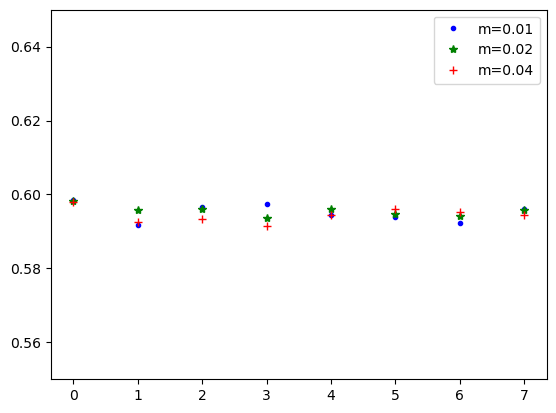

In [20]:
fig1, ax1 = plt.subplots()

ax1.plot(x,P1,'.',color='blue',label='m=0.01')
ax1.plot(x,P2,'*',color='green',label='m=0.02')
ax1.plot(x,P4,'+',color='red',label='m=0.04')
ax1.set_ylim(0.550,0.650)
ax1.legend()

## Meson correlation function

In [30]:
g.default.set_verbose("io", False)
g.default.set_verbose("cg_convergence", False)
g.default.set_verbose("cg", True)

#Ul = [Ul_m001,Ul_m002,Ul_m004]

#associating the gauge field list with the mass 
Ud = {
    0.01: Ul_m001,
    0.02: Ul_m002,
    0.04: Ul_m004,
}

In [65]:

'''
yee haw
'''
def mesons(mass, config):
    mass_fmt = str(mass).replace('.','p') #no idea
    U = Ul_8c16_m004[c]
    D_m = g.qcd.fermion.mobius(U, M5=1.8, mass=mass, Ls=12,b=1.0,c=0.0,boundary_phases=[1,1,1,-1])

    grid = U[0].grid

    inv = g.algorithms.inverter #instantiates inverter
    pc = g.qcd.fermion.preconditioner #instantiates preconditioner
    cg = inv.cg({"eps":1e-7, "maxiter":1000})
    invD = D_m.propagator(inv.preconditioned(pc.eo1_ne(),cg))

    ##point source vs a2a here maybe? 
    src = g.mspincolor(grid) #define the source field
    rng = g.random(str(mass) + "-" + str(config)) #rng, seed is based on mass and config
    t0 = rng.uniform_int(min=0, max=grid.gdimensions[3] - 1) #max is length of t dim
    g.create.wall.z2(src,t0,rng) #generates random wall source, t0 in [0,7]

    #Gaussian smearing
    g.message("smear start")
    smear = g.create.smear.gauss(U,sigma=3.0,steps=30,dimensions=[0,1,2])

    src = g(smear*src) #redefine the source field as the smeared source
    g.message("smear end")

    #
    prop_xy = g(invD * src)
    prop_yx = g(g.gamma[5] * g.adj(prop_xy) * g.gamma[5])

    #<pi pi> = <u_bar gamma_5 d dbar gamma_5 u><Tr[S_xy gamma5 S_yx gamma5]> 
    #investigate why slice is necessary here
    pion_correlator = np.array(g.slice(g.trace(prop_xy * g.gamma[5] * prop_yx * g.gamma[5]),3))
    pion_correlator = np.roll(pion_correlator,-t0)

    #<rho rho>
    rho_correlator = sum([np.array(g.slice(g.trace(prop_xy * g.gamma[i] * prop_yx * g.gamma[i]),3)) for i in range(3)])
    rho_correlator = np.roll(rho_correlator,-t0)

    return {
        "pion": pion_correlator,
        "rho" : rho_correlator
    }


In [66]:
mesons_t16_0p04 = {}
for c in range(10):
    g.message("Config: ",c)
    mesons_t16_0p04[c] = mesons(0.04,c)

GPT :   82778.826961 s : Config:  0
GPT :   82778.867966 s : Initializing gpt.random(0.04-0,vectorized_ranlux24_389_64) took 0.000144243 s
GPT :   82778.905424 s : smear start
GPT :   82781.950481 s : smear end
GPT :   82791.445580 s : cg: converged in 370 iterations
GPT :   82799.688090 s : cg: converged in 354 iterations
GPT :   82808.406976 s : cg: converged in 374 iterations
GPT :   82816.768370 s : cg: converged in 357 iterations
GPT :   82825.179789 s : cg: converged in 367 iterations
GPT :   82834.035007 s : cg: converged in 373 iterations
GPT :   82842.807379 s : cg: converged in 376 iterations
GPT :   82851.721074 s : cg: converged in 377 iterations
GPT :   82860.432732 s : cg: converged in 366 iterations
GPT :   82869.302037 s : cg: converged in 369 iterations
GPT :   82877.829141 s : cg: converged in 358 iterations
GPT :   82886.626234 s : cg: converged in 375 iterations
GPT :   82887.294944 s : Config:  1
GPT :   82887.315323 s : Initializing gpt.random(0.04-1,vectorized_ra

In [50]:
#iterate over config number and create the meson fields for each config 
#save them in a json. 
mesons_0p04 = {}
for c in range(8):
    g.message("Config: ",c)
    mesons_0p04[c] = mesons(0.04, c)

GPT :   14199.109570 s : Config:  0
GPT :   14199.121143 s : Initializing gpt.random(0.04-0,vectorized_ranlux24_389_64) took 0.000189543 s
GPT :   14199.139735 s : smear start
GPT :   14200.845258 s : smear end
GPT :   14204.535252 s : cg: converged in 249 iterations
GPT :   14207.847867 s : cg: converged in 252 iterations
GPT :   14211.220770 s : cg: converged in 254 iterations
GPT :   14214.671047 s : cg: converged in 260 iterations
GPT :   14218.326128 s : cg: converged in 266 iterations
GPT :   14221.433905 s : cg: converged in 252 iterations
GPT :   14224.845140 s : cg: converged in 264 iterations
GPT :   14228.254101 s : cg: converged in 261 iterations
GPT :   14231.616604 s : cg: converged in 256 iterations
GPT :   14234.951747 s : cg: converged in 262 iterations
GPT :   14238.557856 s : cg: converged in 264 iterations
GPT :   14242.069435 s : cg: converged in 261 iterations
GPT :   14242.480686 s : Config:  1
GPT :   14242.488870 s : Initializing gpt.random(0.04-1,vectorized_ra

In [51]:
mesons_0p02 = {}
for c in range(8):
    g.message("Config: ",c)
    mesons_0p02[c] = mesons(0.02, c)

GPT :   14592.462969 s : Config:  0
GPT :   14592.475338 s : Initializing gpt.random(0.02-0,vectorized_ranlux24_389_64) took 0.000139713 s
GPT :   14592.493768 s : smear start
GPT :   14594.232108 s : smear end
GPT :   14598.260039 s : cg: converged in 269 iterations
GPT :   14601.717228 s : cg: converged in 268 iterations
GPT :   14605.065675 s : cg: converged in 259 iterations
GPT :   14608.547049 s : cg: converged in 263 iterations
GPT :   14612.099010 s : cg: converged in 274 iterations
GPT :   14615.715234 s : cg: converged in 273 iterations
GPT :   14619.173762 s : cg: converged in 260 iterations
GPT :   14622.876410 s : cg: converged in 272 iterations
GPT :   14626.572029 s : cg: converged in 273 iterations
GPT :   14630.000502 s : cg: converged in 273 iterations
GPT :   14633.637796 s : cg: converged in 271 iterations
GPT :   14636.870028 s : cg: converged in 268 iterations
GPT :   14637.259870 s : Config:  1
GPT :   14637.268494 s : Initializing gpt.random(0.02-1,vectorized_ra

In [52]:
mesons_0p01 = {}
for c in range(8):
    g.message("Config: ",c)
    mesons_0p01[c] = mesons(0.01, c)

GPT :   14943.873651 s : Config:  0
GPT :   14943.883695 s : Initializing gpt.random(0.01-0,vectorized_ranlux24_389_64) took 0.000174046 s
GPT :   14943.907117 s : smear start
GPT :   14945.642828 s : smear end
GPT :   14949.635845 s : cg: converged in 274 iterations
GPT :   14953.410801 s : cg: converged in 278 iterations
GPT :   14957.002054 s : cg: converged in 275 iterations
GPT :   14960.492524 s : cg: converged in 267 iterations
GPT :   14964.057446 s : cg: converged in 272 iterations
GPT :   14967.713310 s : cg: converged in 276 iterations
GPT :   14971.366965 s : cg: converged in 268 iterations
GPT :   14975.052853 s : cg: converged in 275 iterations
GPT :   14978.814965 s : cg: converged in 277 iterations
GPT :   14982.207270 s : cg: converged in 266 iterations
GPT :   14985.330062 s : cg: converged in 254 iterations
GPT :   14988.681806 s : cg: converged in 267 iterations
GPT :   14989.063460 s : Config:  1
GPT :   14989.071201 s : Initializing gpt.random(0.01-1,vectorized_ra

In [82]:
mesons_t16_0p04[0]["rho"].real.tolist()

[0.7838367920100613,
 1.2362724632339759,
 0.5006220196423211,
 0.343482519843349,
 0.268306295414957,
 0.21976267835956853,
 0.1940846311677914,
 0.1729444689391834,
 0.16587268211600195,
 0.17007345903889304,
 0.1915652518835055,
 0.24305434786447228,
 0.3122187354957221,
 0.3969444655994151,
 0.5495152949013403,
 1.2652612073989113]

In [85]:
class NumpyArrayEncoder(json.JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.real.tolist()
        #elif isinstance(obj, complex): use if the data has an imaginary part that needs to be saved.
        #    return [obj.real,obj.imag]
        return json.JSONEncoder.default(self,obj)

In [84]:
#save meson data in a json
dst="/home/jhildebrand28/hmc_conf/Nf2/8c16/meson_fields/"
fn = "mesons_8c16_0p04.json"

with open(dst+fn,"w") as f:
    json.dump(mesons_t16_0p04,f,cls=NumpyArrayEncoder)

In [87]:
#read meson data from json
dst="/home/jhildebrand28/hmc_conf/Nf2/8c16/meson_fields/"
fn = "mesons_8c16_0p04.json"

mesons_load_0p04 = eval(open(dst+fn).read())
print(mesons_load_0p04.keys())

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])


In [90]:
mesons_load_0p04['0']["rho"]

[0.7838367920100613,
 1.2362724632339759,
 0.5006220196423211,
 0.343482519843349,
 0.268306295414957,
 0.21976267835956853,
 0.1940846311677914,
 0.1729444689391834,
 0.16587268211600195,
 0.17007345903889304,
 0.1915652518835055,
 0.24305434786447228,
 0.3122187354957221,
 0.3969444655994151,
 0.5495152949013403,
 1.2652612073989113]

In [56]:
#save meson fields to json
prefix="/home/jhildebrand28/hmc_conf/Nf2/8c8/meson_fields/"
filename1 = "mesons_0p01.json"
filename2 = "mesons_0p02.json"
filename4 = "mesons_0p04.json"

with open(prefix + filename1,"w") as f:
    json.dump(mesons_0p01,f)

with open(prefix + filename2,"w") as f:
    json.dump(mesons_0p02,f)

with open(prefix + filename4,"w") as f:
    json.dump(mesons_0p04,f)

TypeError: Object of type ndarray is not JSON serializable

In [59]:
type(mesons_0p01[0])

dict

## pion and rho energies

In [107]:
#function to perform thejackknife average given some averaging function f 
#and dataaset (1d array) x
def jackknife_variance_est(f,x):
    N = len(x)
    X = sum(x)/N
    mean = f(X)
    return sum([(f((N*X - x[j])/(N-1)) - mean)**2 for j in range(N)])*(N-1)/N


def bin_data(res, bin_size):
    assert len(res) % bin_size == 0
    n = len(res) // bin_size
    return [sum(res[bin_size*i:bin_size*(i+1)])/bin_size for i in range(n)]

#C(t) = A*(exp(-t * E) + exp(-(T-t)*E))
#function that calculates the energy given the correlation function data
#we first write the t -> inf correlation function, then extract the gs energy
def emp_fold(C):
    Cf = [(C[t] + C[(16-t) % 16])/2.0 for t in range(16)]
    E = [np.arccosh((Cf[t].real + Cf[t+2].real)/2/Cf[t+1].real) for t in range(2,6)]
    return np.array(E)

def mesons_data(data,nbin,tag):
    corrs_p = bin_data(np.array([data[x]["pion"] for x in data]),nbin)
    print(len(corrs_p))
    E_pi = emp_fold(np.mean(corrs_p,axis=0))
    E_pi_err = jackknife_variance_est(emp_fold,corrs_p)**0.5

    corrs_r = bin_data(np.array([data[x]["rho"] for x in data]),nbin)
    print(len(corrs_r))
    E_rho = emp_fold(np.mean(corrs_r,axis=0))
    E_rho_err = jackknife_variance_est(emp_fold,corrs_r)**0.5
    
    t0 = 4
    t1 = 10

    fig2,ax2 = plt.subplots()

    X = len(E_pi)
    ax2.errorbar(np.arange(X),E_pi,E_pi_err,label="pion")
    ax2.errorbar(np.arange(X),E_rho,E_rho_err,label="rho")
    ax2.set_ylim(0.0,1.0)
    ax2.legend()


10
10


TypeError: cannot unpack non-iterable NoneType object

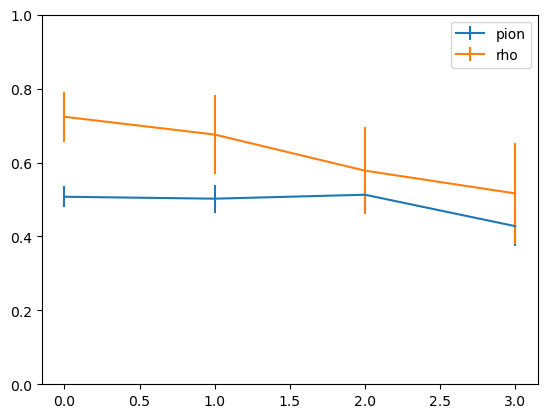

In [108]:
mpi_0p04, mrho0p04 = mesons_data(mesons_t16_0p04,1,"m=0.04")

In [152]:
def jack(data):
    n = len(data)
    jack_data = [(np.sum(data)-data[i])/(n-1) for i in range(n)]
    return np.array(jack_data)
    
def jack_stats(jack_data):
    jack_data = np.asarray(jack_data) 
    
    if jack_data.ndim == 1:
        n = len(jack_data)
        mean  = np.mean(jack_data)
        error = np.sqrt( (n - 1) / n * np.sum((jack_data - mean) ** 2) )
        return mean, error
    
    elif jack_data.ndim == 2: 
        jack_data = jack_data.T
        m, n  = jack_data.shape  # m: rows (time), n: columns (subsets)
        mean  = np.mean(jack_data, axis=1)
        error = np.sqrt( (n - 1) / n * np.sum((jack_data - mean[:, None]) ** 2, axis=1) )
        return mean, error
    else: raise ValueError("Input data must be either 1D or 2D array.")

In [155]:
corrs_pi = np.array([mesons_t16_0p04[x]['pion'] for x in mesons_t16_0p04])
corrs_rho = np.array([mesons_t16_0p04[x]['rho'] for x in mesons_t16_0p04])

cpi_jack = jack(corrs_pi)
crho_jack = jack(corrs_rho)

pi_avg,pi_err = jack_stats(cpi_jack)
rho_avg, rho_err = jack_stats(crho_jack)

In [157]:
X = np.linspace(0,len(pi_avg)-1,len(pi_avg))
len(X)

16

(4.0, 7.0)

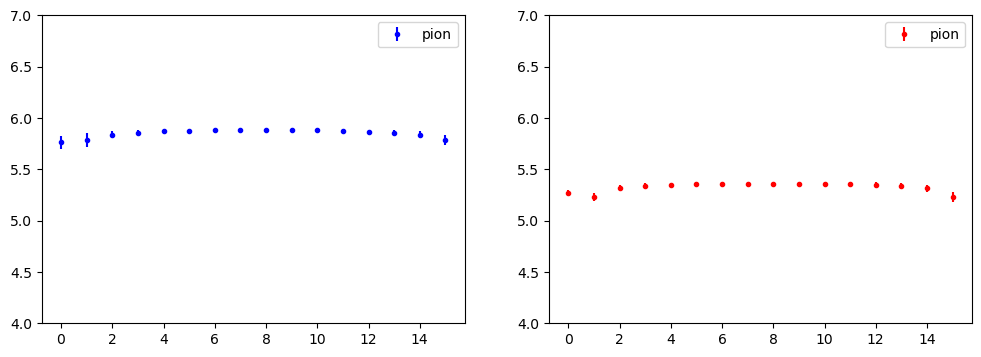

In [163]:
fig3, ax3 = plt.subplots(1,2,figsize=(12,4))
ax3[0].errorbar(X,pi_avg,yerr=pi_err,marker=".",ls="",color="blue",label="pion")
ax3[0].set_ylim(4,7)
ax3[0].legend()
ax3[1].errorbar(X,rho_avg,yerr=rho_err,marker=".",ls="",color="red",label="pion")
ax3[1].legend()
ax3[1].set_ylim(4,7)

In [165]:
-13%12

11